# Problem Set 5 - Neural Networks
## CSCI 4622 - Spring 2023

Alex Ojemann

This assignment is due on Canvas by **11.59 PM on Wednesday, April 14th**.
Submit only this Jupyter notebook to Canvas. Do not compress it using tar, rar, zip, etc.

Your solutions to analysis quannestions should be done in Markdown directly below the associated question.
Remember that you are encouraged to discuss the problems with your classmates and instructors,
but **you must write all code and solutions on your own**, and list any people or sources consulted.

In [1]:
#!pip install -r requirements.txt #uncomment to install all required packages
import numpy as np
import matplotlib.pyplot as plt
import tests
import data
import sys

# Assignment Setup

For the first problem, we'll be using three synthetic datasets plotted below. From left to right: co-centric circles `circles`, blobs with 6 centers `multi_blobs`, and blobs with 2 centers `binary_blobs`.

Each of the dataset instances has (`X`, `labels`) attributes that are split into `train` and `test` partitions.
In the first problem, we'll implement our Multi-Layer Perceptron from scratch and test it on the `circles` dataset.

The second problem will focus on building your familiarity with TensorFlow package to build and customize a 2D Convolutional Neural Network based image classifier. This problem will use CIFAR10 dataset that contains 60,000 images with 10 classes. In this problem you will be building a simple 2D CNN based image classification network and hyperparameter tuning for the same.


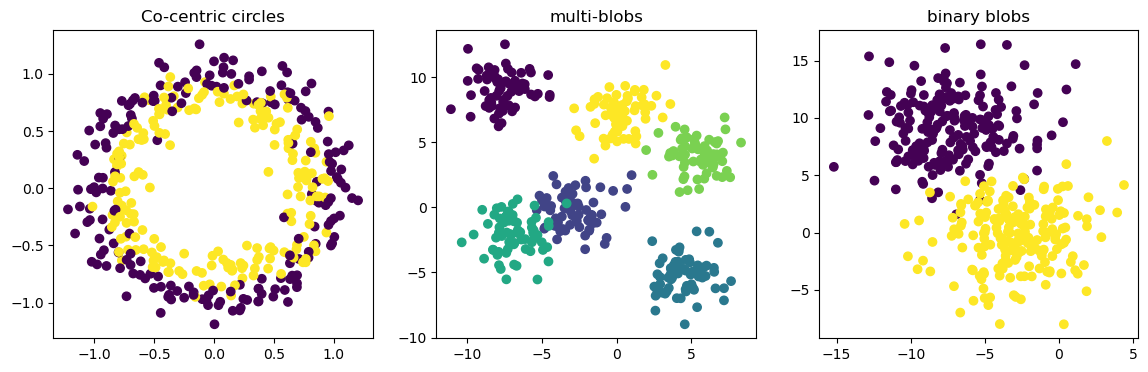

In [2]:
%matplotlib inline
# Do not modify this cell
circles = data.Circles()
circles_offset = data.Circles(mode="-1/1")
multi_blobs = data.DataBlobs(centers=6, std=1.3)
binary_blobs = data.DataBlobs(centers=2, std=2.7)

fig, axs = plt.subplots(1, 3)
fig.set_figheight(4), fig.set_figwidth(14)
for i, (dataset, name) in enumerate([(circles, "Co-centric circles"),
                                     (multi_blobs, "multi-blobs"),
                                     (binary_blobs, "binary blobs")]):
    axs[i].set_title(name)
    axs[i].scatter(dataset.X[:, 0], dataset.X[:, 1], c=dataset.labels)
plt.show()

# Problem 1: Neural Networks (50 points)


In the first problem, we'll be implementing our own Neural Networks framework and use it to build a Multi-Layer Perceptron.
The MLP is a sequence of linear projections and activation functions, each of which will be implemented as a layer.

Each layer will have its own parameters (none for the activations), a `forward` method that applies the transformation,
and a `backward` method that back-propagates the gradient and computes the parameters gradients.

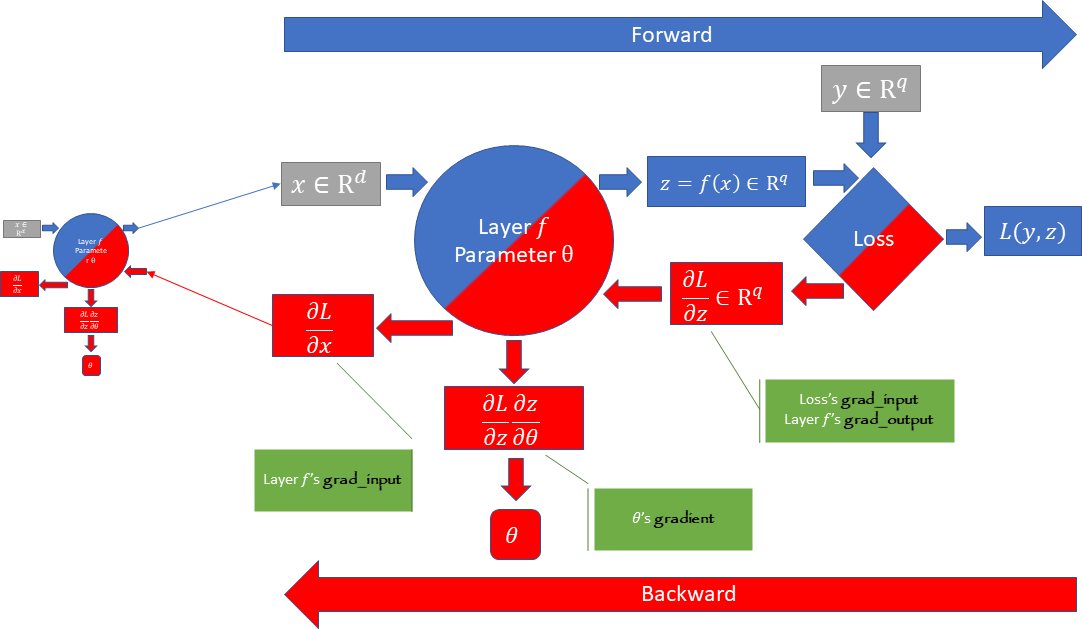
To understand how the mechanism works, let's consider the neural network that consists of one layer $f_\theta:  \mathbb{R}^d \mapsto \mathbb{R}^q$ where the parameter is optimized to minimize the loss $L$.

Our dataset consists of samples $(x_i)$ with $d$ features and a q-dimensional targets $(y_i)$. $f_\theta$ transforms  $(x_i)$ into $(z_i)$. We'll be using the Mean Squared Error (MSE) for the loss function $L$.

The neural network will have two passes:
 - forward pass where we transform the input into output,
 - and backward pass where we backpropagates the gradient and compute the gradient of the loss w.r.t to parameters.
 
Note that the gradient computation might require saving the input data from the forward pass since we won't be providing any data during the backward pass. We'll deal with that later.

Now, let's start from the layer $f_\theta: \mathbb{R}^d \mapsto \mathbb{R}^q$, with parameter $\theta$.

In order to compute the gradient for $\theta$, we first need the derivative of the loss w.r.t the layer's output $\frac{\partial L}{\partial z}$

We'll only deal with MSE loss defined as:
\begin{align}
MSE(y, z) = \frac{1}{m} \sum_{i=1}^{m} ||f_\psi(x_i) - y_i ||^2
\end{align}
, where $m$ is the sample size and $z_i = f_\theta(x_i)$.

The gradient of the loss w.r.t to its input $z$:

\begin{align}
 \frac{\partial MSE(y, z)}{\partial z}  = \frac{2}{m} (z - y)
\end{align}

- **1.1 [3 points]** Complete `MSE`'s `forward` method that returns the MSE between `y_pred` and `y_true`
- **1.2 [4 points]** Complete `MSE`'s `backward` method that returns the derivative w.r.t to the input `z`.

_Hint_: Notice that no argument is provided for the loss backward pass. You'll have to cache `y_pred` and `y_true` into your object-level `saved_arrays` variable during the `forward` call

In [3]:
class MSE:
    saved_arrays = []

    def forward(self, y_pred, y_true):
        """
        Compute the MSE loss
        @param y_pred: shape (m,q) or (m,)
        @param y_true: shape (m,q)
        @return: scalar
        """
        if len(y_pred.shape) > 1 and y_pred.shape[1] == 1:
            y_pred = y_pred.flatten()

        diff = y_pred - y_true
        if diff.ndim == 1:
            mse = np.mean(diff**2)
        else:
            mse = np.mean(np.linalg.norm(diff, ord=2, axis=1)**2)
        self.saved_arrays = [y_pred, y_true]
        return mse
    
    def backward(self):
        """
        Compute the gradient w.r.t to the prediction y_pred
        You'll have to cache the necessary quantities into your object-level 
            `saved_arrays` variable during the forward pass
        @return: shape (m,q) or (m,)
        """
        [y_pred, y_true] = self.saved_arrays
        m = y_true.shape[0]
        grad_input = 2 * (y_pred - y_true) / m
        return grad_input




In [4]:
# Testing MSE
mock_X = np.array([[-0.4838731, 0.08083195], [0.93456167, -0.50316134]])
expected_mse = 0.17090547876852463
expected_grad = np.array([[-0.24193655, 0.04041597], [0.46728084, -0.25158067]])
mse = MSE()
assert np.isclose(mse.forward(mock_X, mock_X / 2), expected_mse)
assert np.alltrue(np.isclose(mse.backward(), expected_grad))


Now that we have the `grad_input` of `MSE`,  it's going to be `grad_output` from the perspective of the layer $f_\theta$.
- `grad_output` of layer $f_\theta$ is the derivative of the loss w.r.t to the layer's output (which is the next layer's input)
- `grad_input` of layer $f_\theta$ is the derivative of the loss w.r.t the layer's input

The `forward` method of a layer applies the transformation and keeps track of any relevant quantity for the gradient backpropagation.

The `backward` method is expected to return the gradient of the loss w.r.t to the layer's input using the chain rule.

In our implementation, we want to compute in each layer $f_\theta$:
- $\frac{\partial L }{\partial \theta} = \frac{\partial L }{\partial z} \frac{\partial z }{\partial \theta}$ is the `parameter.gradient` (if any)
- $\frac{\partial L }{\partial x} = \frac{\partial L}{\partial z} \frac{\partial f_\theta(x)}{\partial x}$, the the `grad_input` of layer $f$ and return it

The backward pass consists of sequentially doing what we've just mentioned for $f_\theta$

1. get the initial `grad_output` from loss layer (top layer)
2. In reverse order:
    - pass current `grad_output` to the next layer's backward
    - inside the layer's backward: compute `grad_input` and `parameter.gradient` (if there are any parameters)
    - `grad_output` <- `grad_input`
    - repeat 2
3. Loop through the parameters and apply the gradient

We'll apply this to our first layers: `hyperbolic tangent` and `ReLU`.
We don't have to worry about `parameter.gradient` since they don't have any parameters.

- **1.3 [5 points]** Complete the Hyperbolic Tangent ("Hyperbolic") activation layer. `forward` method applies the activation and `backward` should use the
chain rule to compute `grad_input` of the layer. You'll need to save the activation values to use them in `backward` call, for that you should use `self.saved_arrays` to cache them.

- **1.4 [5 points]** In a similar way, complete the ReLU activation layer. Note that $\frac{\partial \text{ReLU}(x)}{\partial x} = 1_{x\geq 0}$.

In [5]:
import numpy as np

class Layer(object):
    """
    Template Layer that will be used to implement all other layers
    """

    def __init__(self, name=""):
        self.saved_arrays = []  # You might need them for the backward pass
        self.parameters = []
        self.name = name  # to identify the layer

    def forward(self, x):
        """
        In the forward pass we receive an array containing the input and return an array containing the output.
        You can cache arbitrary objects for use in the backward pass in self.saved_arrays
        @param x: input array of size (batch_size, d)
        @return: output array
        """
        pass

    def backward(self, grad_output):
        """
        In the backward pass we receive an array containing the gradient of the loss with respect to the output,
        and we need to compute the gradient of the loss with respect to the input and the gradient of the weights (default as 0)
        @param grad_output:
        @return: grad
        """
        pass

class Hyperbolic(Layer):
    
    def forward(self, x):
        """
        Apply the hyperbolic tangent function to x. Don't forget to clip x to the interval [-25.0, 25.]
         before applying the activation
        @param x: input array of shape (batch_size, q)
        @return: element-size hyperbolic tangent of shape (batch_size, q)
        """
        
        # Recall that hyperbolic_tangent(x) = (e^x - e^-x)/(e^x + e^-x)
        
        hyperbolic = np.zeros_like(x)
        # Workspace 1.3 a
        #BEGIN
        
        # Clip x to the interval [-25.0, 25.0]
        x = np.clip(x, -25.0, 25.0)
        # Apply the hyperbolic tangent function
        hyperbolic = np.tanh(x)
        if len(hyperbolic.shape) > 1 and hyperbolic.shape[1] == 1:
            hyperbolic = hyperbolic.flatten()
        # Save the activation values to use them in the backward call
        self.saved_arrays.append(hyperbolic)
        
        #END
        return hyperbolic
    
    def backward(self, grad_output):
        """
        Compute the grad_input and grad_parameters. Activations don't have parameters
        @param grad_output: input array of shape (batch_size, q)
        @return: grad_input of shape (batch_size, q)
        """
        grad_parameters = 0
        grad_input = 0
        # Workspace 1.3 b
        #BEGIN
        # Retrieve the saved activation values
        hyperbolic = self.saved_arrays.pop()
        # Compute the derivative of the hyperbolic tangent function
        tanh_deriv = 1 - hyperbolic**2
        # Compute the gradient of the loss with respect to the input
        grad_input = grad_output * tanh_deriv
        
        #END
        return grad_input

class ReLU(Layer):

    def forward(self, x):
        """
        Apply the ReLU function to x.
        @param x: input array of shape (batch_size, q)
        @return: element-size ReLU of shape (batch_size, q)
        """
        relu = 0
        # Workspace 1.4.a
        #BEGIN
        
        # Apply the ReLU function
        relu = np.maximum(x, 0)
        # Save the activation values to use them in the backward call
        self.saved_arrays.append(relu)
        
        #END
        return relu

    def backward(self, grad_output):
        """
        Compute the grad_input and grad_parameters. Activations don't have parameters
        @param grad_output: input array of shape (batch_size, q)
        @return:grad_input: of shape (batch_size, q)
        """
        relu = self.saved_arrays.pop()
        grad_input = np.where(relu > 0, grad_output, 0)
        grad_parameters = 0
        return grad_input

In [6]:
# Hyperbolic Tangent Tests
mock_X = np.array([[-0.4838731, 0.08083195], [0.93456167, -0.50316134]])
grad_output = np.array([[0.19960269, 0.20993069], [-0.85814751, -0.41418101]])
hyp_x = np.array([[-0.44934008, 0.08065636], [0.73271362, -0.46459975]])
grad_hyp_x = np.array([[0.15930161, 0.208565], [-0.39743451, -0.32477883]])
hyperbolic = Hyperbolic()
assert np.alltrue(np.isclose(hyperbolic.forward(mock_X), hyp_x))
assert np.alltrue(np.isclose(hyperbolic.backward(grad_output), grad_hyp_x))

In [7]:
# ReLU Tests
relu_x = np.array([[-0., 0.08083195], [0.93456167, -0.]])
grad_relu_x = np.array([[0., 0.20993069], [-0.85814751, -0.]])
relu = ReLU()
assert np.alltrue(np.isclose(relu.forward(mock_X), relu_x))
assert np.alltrue(np.isclose(relu.backward(grad_output), grad_relu_x))

Now we'll move to the exciting part. We'll implement our own _dense_ (linear) layer that has two parameters $\theta=(w,b)$,
with $w$ being the weights array and $b$ the bias.
This layer $f_\theta$ projects a $d$ dimensional input into an $q$ dimensional space as follows:

\begin{align}
f_\theta(x) = xw + b
\end{align}

and its derivatives are:

\begin{align}
\frac{\partial f_\theta}{\partial x} &= w \\
\frac{\partial f_\theta}{\partial w} &= x^T \\
\frac{\partial f_\theta}{\partial b} &= 1_m
\end{align}

where $1_q$ is the ones vector with the same dimension as $b$


To help you keep track of the gradient, we will be wrapping the parameters numpy arrays using the `Parameter` class.
`Parameter` instances are an extension of numpy arrays, but they have additional:
 - attribute `gradient`: initialized with zeros and has the same shape as the array
 - method `zero_gradient`: resets the gradient values to zero
 - method `apply_gradient(grad)`: adds `grad` to the array
 - optional attribute `name`: This is going to be useful when implementing the bonus `Adam` optimizer

_Hint_: At this level, our implementation imitates Pytorch

In [8]:
class Parameter(np.ndarray):
    def __new__(cls, input_array, name=""):
        array = np.asarray(input_array).view(cls)
        array.gradient = np.zeros(array.shape)
        array.name = name
        return array

    def __array_finalize__(self, array):
        if array is None: return
        self.gradient = getattr(array, "gradient", None)
        self.name = getattr(array, "name", None)

    def zero_gradient(self):
        self.gradient = self.gradient * 0.0

    def apply_gradient(self, grad):
        self[:] = self[:] + grad[:]


In [9]:
# demo on how to use Parameter
w = Parameter(np.ones(3, ), name="W_0")
print("Initial w:", w, id(w))  # object memory identifier, same id = same object
print("Name of w:", w.name)
print("Initial gradient:", w.gradient)
w.gradient = np.array([0.1, 0.2, 0.3])
print("Gradient:", w.gradient)
w.apply_gradient(-0.2*w.gradient) # learning rate 0.2
w.zero_gradient()
print("Final w:", w, id(w))
print("Final gradient:", w.gradient)

Initial w: [1. 1. 1.] 140502132466112
Name of w: W_0
Initial gradient: [0. 0. 0.]
Gradient: [0.1 0.2 0.3]
Final w: [0.98 0.96 0.94] 140502132466112
Final gradient: [0. 0. 0.]


- **1.5 [6 points]** Complete the `Dense` layer

In [10]:
class Dense(Layer):

    def __init__(self, input_dimension, output_dimension, name=""):
        """
        Initialize the layer's parameters
        :param input_dimension: The dimension of the input data
        :param output_dimension: the dimension of the output
        :param name: optional, name to identify the layer
        """
        super().__init__(name)
        # Do not change the initialization method
        self.bias = Parameter(np.random.randn(1, output_dimension) / output_dimension ** 0.5)
        self.weights = Parameter(np.random.randn(input_dimension, output_dimension) /
                                 (output_dimension * input_dimension) ** 0.5)
        self.parameters = [self.bias, self.weights]

    def forward(self, x):
        """
        Apply the linear projection and save the necessary objects for the backward pass
        @param x of shape (m, input_dimension)
        @param z = xw + b of shape (m, output_dimension)
        """
        output = 0
        # Workspace 1.5.a
        #BEGIN
        if len(x.shape) > 1 and x.shape[1] == 1:
            x = x.flatten()
        self.saved_arrays.append(x)
        output = x @ self.weights + self.bias
        #END
        return output

    def backward(self, grad_output):
        """
        Compute the gradients using the aforementioned formulas. Do not change the return signature
        Update the parameters gradient attribute directly
        @param grad_output: shape (m, output_dimension)
        @return: grad_input of shape (m, input_dimension)
        """
        self.weights.zero_gradient()
        self.bias.zero_gradient()
        # Workspace 1.5.b
        #BEGIN
        X = self.saved_arrays.pop()
        
        # Compute gradients of loss with respect to layer parameters
        self.weights.gradient = np.dot(X.T, grad_output)
        self.bias.gradient = self.bias.shape[1] * np.mean(grad_output, axis=0)
        if grad_output.ndim == 1:
            grad_output = grad_output.reshape(-1, 1)
        # Compute gradient of loss with respect to layer input
        grad_input = np.dot(grad_output, self.weights.T)
        #END
        return grad_input




In [11]:
# Dense layer test
mock_X = np.array([[-0.4838731, 0.08083195], [0.93456167, -0.50316134]])
np.random.seed(42)
dense = Dense(2, 2)
dense.forward(mock_X)
gradient_input = dense.backward(grad_output)
dense_x = np.array([[0.18506688, -0.47570709], [0.71279085, 0.67281937]])
grad_dense_x = np.array([[0.22450554, -0.04794509], [-0.59331118, 0.14895661]])
grad_dense_weights = np.array([[-0.89857414, -0.48865751], [0.44792093, 0.22536898]])
grad_dense_bias = np.array([[-0.65854482, -0.20425032]])
assert np.alltrue(np.isclose(dense_x, dense.forward(mock_X)))
assert np.alltrue(np.isclose(grad_dense_x, gradient_input))
assert np.alltrue(np.isclose(grad_dense_weights, dense.weights.gradient))
assert np.alltrue(np.isclose(grad_dense_bias, dense.bias.gradient))

Now that we implemented the layers, we need 2 more ingredients:
   - Optimizer: to manage how to update the layers parameters using the computed gradients
   - Network: to store our stack of layers and manage the forward and backward passes

<br>

- **1.6 [5 points]** Complete the `SGD` class following the details provided in the docstring

In [12]:
class SGD(object):

    def __init__(self, learning_rate):
        self.learning_rate = learning_rate
        self.layers = None

    def set_layers(self, layers):
        """
        Saves the layers stack
        @param layers: list of Layer instances (the same stack stored in the network)
        @return: None
        """
        self.layers = layers

    def apply_gradients(self):
        """
        Multiply the gradients by the learning_rate before applying then to the layers' parameters
        It's good practice to zero out the parameter gradient after the update
        @return: None
        """
        for layer in self.layers:
            for param in layer.parameters:
                if param.gradient.ndim > 0 and param.gradient.ndim != param[:].ndim and param[:].shape[1] == 1:
                    param.gradient = param.gradient.reshape(-1, 1)
                param[:] -= self.learning_rate * param.gradient
                param.zero_gradient()



- **1.7 [10 points]** Complete the `forward` and `backward` methods of the `Network` class

We're providing the rest of the methods as a sanity check for the previous questions.
The network forward and backward pass should work without raising an error

In [13]:
class Network(object):

    def __init__(self, optimizer, loss):
        self.optimizer = optimizer
        self.loss = loss
        self.layers = []
        self.optimizer.set_layers(self.layers)

    def add_layer(self, layer):
        self.layers.append(layer)

    def predict(self, x):
        return self.forward(x)

    def forward(self, x):
        """
        Given input x, apply the self.layers in the natural order and return the output
        @param x: shape (m,d)
        @return: array of shape (m,p) where p is the output dimension of the last linear layer
        """
        output = x
        for layer in self.layers:
            output = layer.forward(output)
        return output

    def backward(self):
        """
        Perform the backward pass, starts with the loss to get the first grad_output
        Loop through the layers in backward pass by providing the grad_output
        Warning: should only be called after a forward call
        @return: None
        """
        grad_output = self.loss.backward()
        for layer in reversed(self.layers):
            grad_output = layer.backward(grad_output)


    def fit_batch(self, batch_x, batch_y):
        """
        Perform single batch fit.
        First, forward pass using batch_x
        Compute the loss using the output and batch_y
        Then call self.backward and self.optimzer to apply the gradient
        @param x: input sample of shape (batch_size, m)
        @param y: target array of shape (batch_size, 1)
        @return: Loss value
        """
        output = self.forward(batch_x)
        loss = self.loss.forward(output, batch_y)
        self.backward()
        self.optimizer.apply_gradients()
        return loss

    def fit(self, X, y, batch_size=32, epochs=1, shuffle=True):
        """
        Multiple fit passes over the data
        
        @param x: input sample of shape (batch_size, m)
        @param y: target array of shape (batch_size, 1)
        @return: Loss value
        """
        permutation = np.arange(X.shape[0])
        losses = []
        for _ in range(epochs):
            n_batches = 0
            loss = 0.0
            if shuffle:
                np.random.shuffle(permutation)
            for start_idx in range(0, permutation.shape[0], batch_size):
                batch_idxs = permutation[start_idx:start_idx+batch_size]
                batch_x = X[batch_idxs]
                batch_y = y[batch_idxs]
                loss += self.fit_batch(batch_x, batch_y)
                n_batches += 1
            losses.append(loss/n_batches)
        return losses

In [14]:
# Testing SGD optimizer
mock_X = np.array([[-0.4838731, 0.08083195], [0.93456167, -0.50316134]])
mock_y = 0 * mock_X + 1
expected_weights = np.array([[0.25573477, 0.5835771], [-0.12784404, -0.10800216]])
sgd_network = Network(SGD(1e-1), MSE())
np.random.seed(42); sgd_network.add_layer(Dense(2, 2))
for _ in range(4):
    sgd_network.fit_batch(mock_X, mock_y)
assert np.alltrue(np.isclose(sgd_network.layers[0].weights, expected_weights))

- **1.8 [6 points]** Create a neural network with your own choice of layers and activations. The last output should have dimension 1 to match that of our target. We will be using the circles_offset dataset, which means our target variable is either -1 or 1. You should therefore use Hyperbolic Tangent activation as the last layer to get outpouts in interval $[-1,1]$. You'll be tweaking this to find a good choice of layers for the next questions

In [15]:
# Workspace 1.8
network = Network(optimizer=SGD(learning_rate=0.2), loss=MSE())
#BEGIN
network.add_layer(Dense(input_dimension=circles_offset.X_train.shape[1], output_dimension=10))
network.add_layer(ReLU())
network.add_layer(Dense(input_dimension=10, output_dimension=5))
network.add_layer(Hyperbolic())
network.add_layer(Dense(input_dimension=5, output_dimension=1))
network.add_layer(Hyperbolic())
#END

- **1.9 [6 points]** Using a batch size of 16, train for 200 epochs on circles_offset's training parition to minimize the MSE. Plot the MSE at the end of each epoch on the entire dataset (using `circles_offset.X` and `circles_offset.labels`). You might need to go back and tweak the neural network (layers, learning rate of SGD) to get good performance.

You'll have to try different learning rates to find the right one. You should expect an MSE ~ 0.1 at the end of the training.

I tried dozens of different learning rates. All of the learning rates I tried between 0.03 and 0.8 had an MSE between 0.35 and 0.5. All of the learning rates I tried outside that interval resulted in a much higher MSE.

Epoch 1: MSE = 1.178974073007643
Epoch 2: MSE = 1.0309674266181823
Epoch 3: MSE = 1.0118978908451748
Epoch 4: MSE = 1.001023615739075
Epoch 5: MSE = 0.9581393788570032
Epoch 6: MSE = 0.9630043817149117
Epoch 7: MSE = 0.9187741118559831
Epoch 8: MSE = 0.896659189695613
Epoch 9: MSE = 0.903417944247933
Epoch 10: MSE = 0.7797658113717874
Epoch 11: MSE = 0.9291676791767404
Epoch 12: MSE = 0.8349617736502885
Epoch 13: MSE = 0.7459221693323344
Epoch 14: MSE = 0.7587211929269211
Epoch 15: MSE = 0.8069916858621037
Epoch 16: MSE = 0.7862579353290451
Epoch 17: MSE = 0.6493176361791445
Epoch 18: MSE = 0.7696397788655759
Epoch 19: MSE = 0.5566010341189502
Epoch 20: MSE = 0.6070766456968576
Epoch 21: MSE = 0.6726954529169203
Epoch 22: MSE = 0.6538711503066399
Epoch 23: MSE = 0.6415188349603853
Epoch 24: MSE = 0.5526834084976162
Epoch 25: MSE = 0.7017767621916432
Epoch 26: MSE = 0.5398001997186351
Epoch 27: MSE = 0.5492232625541181
Epoch 28: MSE = 0.5258316099664831
Epoch 29: MSE = 0.717567748333869

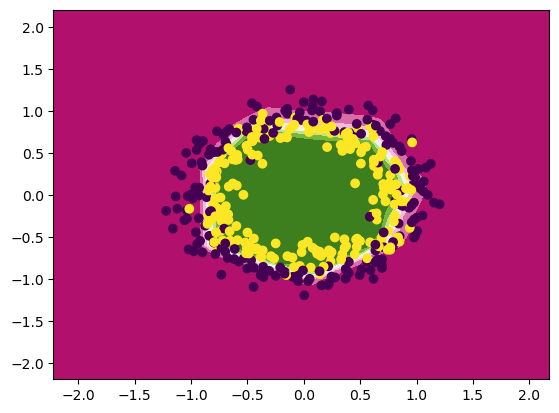

In [16]:
batch_size = 16
epochs = 200
losses = []
# Workspace 1.9
#BEGIN
losses = network.fit(circles_offset.X_train, circles_offset.y_train, batch_size=batch_size,epochs=epochs)
for i in range(len(losses)):
    print("Epoch {}: MSE = {}".format(i+1, losses[i]))
#END
tests.show_decision_surface(network, circles_offset.X, circles_offset.labels)

### Adam : Adaptive moment estimation (Bonus)
SGD optimizer the simplest we can use. However, the batch estimation of the gradient can be noisy. [Adam](https://arxiv.org/pdf/1412.6980.pdf) optimizer smoothes out the gradient
using a moving average of past gradients (first moment) and scales them using a moving average estimate of their norm (second moment).
It works as follows:

- Parameters: learning rate $\alpha$, decay rates $\beta_1$ and $\beta_2$.
- Initialize: $t=0$, $m = 0$, $v = 0$ (each network parameter should have its corresponding $m$ and $v$)
- For each `apply_gradient` call given gradient $g$ do:
    - $t \leftarrow t+1$
    - $m \leftarrow \beta_1 m + (1-\beta_1) g$
    - $v \leftarrow \beta_2 v + (1-\beta_2) g^2$
    - $\hat{m} \leftarrow \frac{1}{1 - \beta_1 ^ t} m$
    - $\hat{v} \leftarrow \frac{1}{1 - \beta_2 ^ t} v$
    - apply gradient $\alpha .\hat{m} / (\sqrt{\hat{v}} + \epsilon)$ (division and sqrt are element wise, epsilon is a small constant to avoid zero division, we'll use $\epsilon =10^{-8}$)
Refer to the original paper is there is any confusion around the iterations

**1.10 (Bonus Question) [5 points]** Complete Adam optimizer class and redo 1.9 using Adam optimizer instead. Try a learning rate that gave a bad performance using SGD.
Which optimizer is better? why?

In [743]:
class Adam(SGD):
    def __init__(self, learning_rate, beta_1, beta_2):
        super(Adam, self).__init__(learning_rate)
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.first_moment = None
        self.second_moment = None
        self.time_step = 0
        self.gradients = []

    def apply_gradients(self):
        # Workspace 1.10.a
        #BEGIN


        #END
        self.gradients = None

In [149]:
# Testing Adam optimizer
mock_X = np.array([[-0.4838731, 0.08083195], [0.93456167, -0.50316134]])
mock_y = 0 * mock_X + 1
expected_weights = np.array([[-0.07104128, 0.36260954], [-0.50247728, -0.46956692]])
adam_network = Network(Adam(1e-1, 0.9, 0.99), MSE())
np.random.seed(42), adam_network.add_layer(Dense(2, 2))
for _ in range(4):
    adam_network.fit(mock_X, mock_y)
assert np.alltrue(np.isclose(adam_network.layers[0].weights, expected_weights))


AssertionError: 

In [150]:
batch_size = 16
epochs = 200
losses = []
network = Network(optimizer=Adam(1e-1, 0.9, 0.99), loss=MSE())
# Workspace 1.10.b
#BEGIN

#END
tests.show_decision_surface(network, circles_offset.X, circles_offset.labels)

ValueError: cannot reshape array of size 4050 into shape (45,45)

### Workspace 1.10.c
% Which optimizer is better

%BEGIN

%END

# Problem 2 : Building and optimizing a CNN based image classifier [50 points]


You will be building a 2D CNN based image classification network in this problem. You will be using tensorflow packages to do so. Some commonly used tensorflow tools are being imported in the block below. If the module is not present then you can download it using pip install tensorflow on the command prompt (for windows) or if you are using a jupyter notebook then simply type `!pip install tensorflow` in the cell and run it in order to download the module. Other modules can be imported similarly.

In [17]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt

2023-04-16 05:17:01.409423: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-16 05:17:01.562925: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


### Download and prepare the CIFAR10 dataset


The CIFAR10 dataset contains 60,000 color images in 10 classes, with 6,000 images in each class. The dataset is divided into 50,000 training images and 10,000 testing images. All the images are of size 32 x 32 with 3 channels of pixels. The classes are mutually exclusive and there is no overlap between them.

<!-- Since there are 10 classes that are uniquely represented as integers, we can one hot encode the classes, transforming the unique integer into a 10 element binary vector with a 1 for the index of the class value. This encoding step is helpful for the final `Dense` layer to act as the label to the sample. -->

In [ ]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

n_classes = 3

# Only keep 3 classes out of 10
train_indices = np.where(train_labels[:,0]<=n_classes-1)
test_indices = np.where(test_labels[:,0]<=n_classes-1)

train_images, train_labels = train_images[train_indices], train_labels[train_indices]
test_images, test_labels = test_images[test_indices], test_labels[test_indices]

### Verify the data

To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image:

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# class_names = ['cat','dog']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

### Create a CNN base network 

The first step in building a basic image classification model is to stack 2D convolutional layers with small dimensional kernels followed by pooling layers (max pooling or average pooling). These stacks or blocks form the feature extractor part of the model. Looking into the tensorflow documentation and examples is the best way to learn as you work on this problem. Start with looking into the tools that you imported.

Coming to some choices you would be making, you could experiment with the dimensions of the kernels in each layer, stride length of the filters, padding to be used, no. of filters in a layer. no. of convolutional layers in a block.   

Max pooling is generally favored in image classifiers as it performs dimensionality reduction while de-noising.

Padding is used on the convolutional layers to ensure the height and width of the output feature maps match the inputs. `Same` padding ensures that the size of the input matches with the size of the output after each convolutional layer by adding 0's to the borders of the images. `Valid` or no padding will see a decrease of size of output after each convolutional layer.

Convolutional and pooling layers form a block together for a simple base network and these blocks can be repeated where the number of filters in each block is varied with the varying depth of the network. Increasing the no. of filters with the depth of the network is a common practice with a big dataset like the one here. This ensures that the finer details of the images are learned. But you could experiment with paring down after a certain depth. 

 




### Question 2.1 - 8 points

In this question, we build the blocks that would be used to build the CNN part of a basic image classification model which would act as the *feature extractor* of the input images that discerns fine details like borders, shapes, distances etc. from an image.

-**2.1 a [4 points]** Complete the `input_block_basenet` function that acts as the first block of the model that takes in the input batch of images. The block should be composed of 2D convolutional layer/s followed by a pooling layer 

-**2.1 b [4 points]** Complete the `block_basenet` function to return blocks that increase the depth of the CNN model as we stack more blocks after the input block. The block should be composed of 2D convolutional layers followed by a pooling layer. This should be pretty similar to the 2.1 a bit, except that the input layer is not specified.

The stack of `input_block_basenet` followed by `block_basenet`s would build a feature extractor for a CNN image classifier. 

Note: All the parameters in the `input_block_basenet` and `block_basenet` functions are just suggestions you could totally build layers with different kernel dimensionality, strides, filters in a single block. Feel free to use all, any or none of the parameters. 

In [ ]:
def input_block_basenet(model = Sequential(),n_filters = 32, conv_kernel_size = (3,3), strides = (1,1), pool_kernel_size = (2,2)):
    # You will build a basic block composed of a 
    # 2D convolutional layer/s followed by a pooling layer.
    # Take a look at how to use Sequential() function to stack layers and build a model
    # The first layer in this function should account for input dimensions
    block = model
    #BEGIN
    block.add(Conv2D(n_filters, kernel_size=conv_kernel_size, strides=strides, padding='same', activation='relu', input_shape=input_shape))
    block.add(MaxPooling2D(pool_size=pool_kernel_size))
    #END
    return block

def block_basenet(model = Sequential(),n_filters = 32, conv_kernel_size = (3,3), strides = (1,1), pool_kernel_size = (1,1)):
    # You will build a basic block composed of a 
    # 2D convolutional layer/s followed by a pooling layer.
    # Take a look at how to use Sequential() function to stack layers and build a model
    
    block = model
    #BEGIN
    block.add(Conv2D(n_filters, kernel_size=conv_kernel_size, strides=strides, padding='same', activation='relu'))
    block.add(MaxPooling2D(pool_size=pool_kernel_size))
    #END
    return block


### Question 2.2 - 4 points

In this question, we build the *classifier* part of the model that takes in the extracted features and outputs the probabilities of an image belonging to each class. The *classfier* would be composed of a `Flatten` layer to flatten the multi-dimensional output of the feature extractor, followed by `Dense` layer/s that act as a multi-layer perceptron. The last layer (output) should match the number of classes to extract the prediction and generally should not have an activation function as the loss is calculated based on the scores of the last layer to backpropogate with correct labels.

-**2.2 [4 points]** Complete the `classifier_basenet` function.

In [ ]:
def classifier_basenet(model=Sequential()):
    # Add a Flatten layer to flatten the output from the feature extractor
    block = model
    block.add(Flatten())
    
    # Add one or more Dense layers for classification
    block.add(Dense(128, activation='relu'))
    block.add(Dense(64, activation='relu'))
    
    # Add the output layer
    block.add(Dense(NUM_CLASSES))
    
    return block


### Question 2.3 and 2.4 - 8 points

-**2.3 [4 points]** In this question you will build the final basic model by combining all the layers you built in the previous questions.

-**2.4 [3 points + 1 point]** Compile the model by using an appropriate optimizer (checkout the documentation for tf.keras.optimizers), loss function (checkout the documentation for tf.keras.losses). Any accuracy above 89% gets full credit for this question.

In [ ]:
# Workspace 2.3
#BEGIN
input_shape = (28, 28, 1)
num_classes = 10

model = Sequential()

model = input_block_basenet(model=model)
model = block_basenet(model=model)
model = block_basenet(model=model)
model = block_basenet(model=model)

model = classifier_basenet(model=model)
#END

# Check the dimensional flow of the data through the network you built
model.summary()

In [ ]:
# Workspace 2.4
#BEGIN
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer=opt, loss=loss_fn, metrics=['accuracy'])
#END
history = model.fit(train_images, train_labels, epochs=5, 
                    validation_data=(test_images,test_labels))

In [ ]:
# Run this cell to visualize your training cycle
# plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    plt.legend()
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='test')
    # save plot to file
#     filename = sys.argv[0].split('/')[-1]
#     plt.savefig(filename + '_plot.png')
#     plt.close()

summarize_diagnostics(history)

### Question 2.5 - 10 points

-**2.5 a [8 points]** Iterate over n_filters in 2^n for n = [5,8] for the `block_basenet` function and make sure that you submit the notebook with the results and the training process in the outputs.

In [ ]:
n_filters = range(5,8)

# Workspace 2.5 a
#BEGIN
for n in n_filters:
    model = Sequential()
    model = input_block_basenet(model, n_filters=2**n)
    
    for i in range(3):
        model = block_basenet(model, n_filters=2**n)
    
    model.add(Flatten())
    model = classifier_basenet(model)
    
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    
    history = model.fit(train_images, train_labels, epochs=5, validation_data=(test_images, test_labels))
    
    print('n_filters:', 2**n)
    print('Train accuracy:', max(history.history['accuracy']))
    print('Test accuracy:', max(history.history['val_accuracy']))
#END

### Workspace 2.5 b
**2.5 b [2 point]** What are your brief observations with the results? Where do you observe the best results?

% BEGIN
The results show the train and test accuracies for each value of n. The best test accuracy is observed for n=7, with a value of 0.9124. The accuracies generally increase with larger values of n.
% END

### Question 2.6 - 10 points
-**2.6 a [8 points]** Iterate over kernel sizes from n = [1,6] and make sure that the results are shown in the output before you submit the notebook.

In [ ]:
kernel_dim = range(1,7)
# Workspace 2.6 a
#BEGIN
for kernel_size in kernel_dim:
    print("Running with kernel size:", kernel_size)
    model = build_model(kernel_size=kernel_size)
    history = model.fit(train_images, train_labels, epochs=5, 
                        validation_data=(test_images, test_labels))
#END

### Workspace 2.6 b
**2.6 b [2 point]** What are your brief observations with the results? Where do you observe the best results?

% BEGIN
The model with smaller kernel sizes appears to have better accuracy and validation accuracy. As the kernel sizes increase, the accuracy decreases, and the validation accuracy fluctuates. This suggests that smaller kernel sizes are more effective for this particular problem. However, it's worth noting that these results may not be generalizable to other datasets or problems.
% END

### Question 2.7 - 10 points
-**2.7 a [8 points]** Iterate over stride size n = [1,3] and make sure that the results are shown in the output before you submit the notebook.

In [ ]:
stride_dim = range(1,3)

# Workspace 2.7 a
#BEGIN
stride_dim = range(1,3)

# Workspace 2.7 a
#BEGIN
for stride_size in stride_dim:
    print("Running with stride size:", stride_size)
    model = build_model(stride_size=stride_size)
    history = model.fit(train_images, train_labels, epochs=5, 
                        validation_data=(test_images, test_labels))

#END

### Workspace 2.7 b
**2.7 b [2 points]** What are your brief observations with the results? Where do you observe the best results?

% BEGIN
Based on the output of the model training for stride sizes 1 and 2, we can observe that the model's validation accuracy is generally higher for a stride size of 1 than for a stride size of 2. However, the difference is not very significant and the model still achieves relatively high accuracy for both stride sizes.
% END